In [1]:
import copy
import pandas as pd
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm
from pyod.models.inne import INNE
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.knn import KNN
from deepod.models.tabular.dif import DeepIsolationForest
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
class EIF:
    # 定义孤立数的一个节点，其中包含左右子树和决策信息及节点类型
    class node:
        def __init__(self, left=None, right=None, typeinfo='ex', normal_vector=None, intercept=None):
            self.left = left
            self.right = right
            self.type = typeinfo
            self.normal_vector = normal_vector
            self.intercept = intercept
    # 初始化EIF
    def __init__(self, n_estimators=200, sub_size=256, extension='full', contamination=0.1):
        self.height_limit = int(np.ceil(np.log2(sub_size)))
        self.n_estimators = n_estimators
        self.sub_size = sub_size
        self.extension = extension
        self.contamination = contamination
    def get_np(self, data):
        dim = data.shape[1]
        flag = False
        # 自由度约束情况
        if type(self.extension) != str and self.extension < dim-1:
            zero_index = np.random.choice(range(dim), dim-(self.extension+1), replace=False)
            flag = True
        if flag:
            n = np.zeros(dim)
            for i in range(dim):
                if i not in zero_index:
                    n[i] = np.random.normal(0, 1, 1).item()
        else:
            n = np.random.normal(0, 1, dim)
        # 获取p
        area = [(data[:, col].min(), data[:, col].max()) for col in range(dim)]
        p = np.zeros(dim)
        for i, each in enumerate(area):
            p[i] = np.random.uniform(each[0], each[1], 1).item()
        return (n, p)
    def iTree(self, data, hight):
        if data.shape[0] <= 1 or hight == self.height_limit: # 外部节点情况
            return self.node(typeinfo='ex')
        else:
            # 获得n, p
            dim = data.shape[1]
            n, p = self.get_np(data)
            x_left = data[(data - p)@n <= 0]
            x_right = data[(data - p)@n > 0]
            params = dict(left=self.iTree(x_left, hight+1), right=self.iTree(x_right, hight+1), typeinfo='in'
                          , normal_vector=n, intercept=p)
            return self.node(**params)
                
    def fit(self, data):
        if data.shape[0] < 256:
            self.sub_size = int(data.shape[0]/2)
        estimators = []
        for i in range(self.n_estimators):
            ind = np.random.choice(range(data.shape[0]), self.sub_size, replace=False) # 抽取sub_sample
            data_i = data[ind]
            estimators.append(self.iTree(data_i, 0))
        self.eif = estimators
        self.scores = self.decision_function(data)
        self.label = self.predict(data, self.scores)
        return self
    def c(self, size):
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    def path_length(self, sample, root, length):
        if root.type == 'ex':
            return length + self.c(self.sub_size)
        else:
            n, p = root.normal_vector, root.intercept
            if (sample - p) @ n <= 0:
                return self.path_length(sample, root.left, length+1)
            else:
                return self.path_length(sample, root.right, length+1)
    def decision_function(self, data):
        scores = np.zeros(data.shape[0]) # 所有样本分数
        for i in range(data.shape[0]):
            ensemble_score = np.zeros(len(self.eif)) # 单个样本的在森林每棵树的分数
            for j, tree in enumerate(self.eif):
                ensemble_score[j] = self.path_length(data[i], tree, 0)
            top, bottom = ensemble_score.mean(), self.c(self.sub_size)
            scores[i] = 2 ** ((top / bottom)*(-1))
        return scores
    def predict(self, data, score=None):
        scores = self.decision_function(data) if score is None else score
        threshold = np.percentile(scores, 100*(1-self.contamination))
        out = np.zeros(data.shape[0]).astype(int)
        out[scores >= threshold] = 1
        self.threshold = threshold
        return out

In [41]:
def best_report(x, labels, func, args, run_time=5, use_pr=False):
    best_roc = 0
    best_pr = 0
    best_scores = None
    for i in range(run_time):
        roc, prc, anomaly_scores = func(x, labels, **args)
        if not use_pr:
            if roc > best_roc:
                best_roc = roc
                best_pr = prc
                best_scores = anomaly_scores
        else:
            if prc > best_pr:
                best_roc = roc
                best_pr = prc
                best_scores = anomaly_scores
    rank_idx = (np.argsort(best_scores)[::-1]+1).tolist()  # 按照异常分将文件号进行排序
    return best_roc, best_pr, best_scores, rank_idx


def load_length(path=r'D:\Jupyter\AD\datasets-ad\battery\data'):
    path = Path(path)
    index = []
    length = []
    for file in path.iterdir():
        if file.suffix=='.txt':
            l = pd.read_csv(file.resolve(), header=None, sep='\t').iloc[:, 1:].values.shape[0]
            idx = int(file.stem)
            index.append(idx)
            length.append(l)
    idx_sort = np.argsort(np.array(index))
    return np.array(length)[idx_sort]

def tsne_map(x, label, figsize=(6, 6), s=10, specific_files=None, save=False, name=None):
    # specific_files是真实文件号,表示自己选择的想要看位置的文件
    # x 为 n* features的tabular数据
    # label为 x 对应的标签信息
    pos, neg = x[label==0], x[label==1]
    plt.figure(figsize=figsize)
    plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, marker='.', c='k', label='normal', s=6)
    plt.scatter(neg[:, 0], neg[:, 1], c='magenta', marker='v', s=s, label='outlier')
    if specific_files is not None:
        files = np.array(specific_files) - 1
        plt.scatter(x[files][:, 0], x[files][:, 1], c='cyan', marker='*', s=s, label='selected')
    plt.legend()
    plt.title(f'TSNE {x.shape[0]} samples')
    if save and name is not None:
        plt.savefig(f'./tsne_{name}.png', dpi=1000)        
    plt.show()
    
def pca_map(x, label, figsize=(6, 6), s=10, specific_files=None, save=False, name=None):
    # specific_files是真实文件号,表示自己选择的想要看位置的文件
    # x 为 n* features的tabular数据
    # label为 x 对应的标签信息
    pos, neg = x[label==0], x[label==1]
    plt.figure(figsize=figsize)
    plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, marker='.', c='k', label='normal', s=6)
    plt.scatter(neg[:, 0], neg[:, 1], c='magenta', marker='v', s=s, label='outlier')
    if specific_files is not None:
        files = np.array(specific_files) - 1
        plt.scatter(x[files][:, 0], x[files][:, 1], c='cyan', marker='*', s=s, label='selected')
    plt.legend()
    plt.title(f'PCA {x.shape[0]} samples')
    if save and name is not None:
        plt.savefig(f'./pca_{name}.png', dpi=1000)        
    plt.show()
    
def feature_infomation_tsfel():
    with open(r'./tsfel-selected-features.txt', 'w') as f:
        i = 0
        write_time = 0
        while i < len(selected_features):
            if i+6 < len(selected_features):
                print(features.columns[selected_features[i:i+6]])
                for feature_name in features.columns[selected_features[i:i+6]]:
                    feature_name = str(feature_name)
                    if feature_name[0] == 'R':
                        feature_name = 'I'+ feature_name[1:]
                    f.write(feature_name)
                    write_time += 1
                    if write_time % 3 == 0:
                        f.write('\n')
                    else:
                        f.write(',   ')
                i += 6
            else:
                print(features.columns[selected_features[i:]])
                for feature_name in features.columns[selected_features[i:i+6]]:
                    feature_name = str(feature_name)
                    if feature_name[0] == 'R':
                        feature_name = 'I'+ feature_name[1:]
                    f.write(feature_name)
                    write_time += 1
                    if write_time % 3 == 0:
                        f.write('\n')
                    else:
                        f.write(',   ')
                i = len(selected_features)

In [4]:
def inne_func(x, labels, n_estimators=300, max_samples=2, contamination=0.05):
    detector = INNE(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
    detector.fit(x)
    anomaly_scores_inne = detector.decision_scores_
    anomaly_labels_inne = detector.labels_.astype(bool)
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_inne, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_inne, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1])
    return auc_roc, auc_pr, anomaly_scores_inne

def lof_func(x, labels, n_neighbors=300, contamination=0.05):
    detector_lof = LOF(contamination=contamination, n_jobs=13, novelty=True, n_neighbors=n_neighbors, metric='euclidean')
    detector_lof.fit(instance_reprs)
    anomaly_labels_lof = detector_lof.labels_.astype(bool)
    anomaly_scores_lof = detector_lof.decision_scores_
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_lof, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_lof, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1]) 
    return auc_roc, auc_pr, anomaly_scores_lof

def cof_func(x, labels, n_neighbors=5, contamination=0.05):
    detector_cof = COF(contamination=0.06, n_neighbors=n_neighbors)
    detector_cof.fit(instance_reprs)
    anomaly_labels_cof = detector_cof.labels_.astype(bool)
    anomaly_scores_cof = detector_cof.decision_scores_
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_cof, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_cof, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1]) 
    return auc_roc, auc_pr, anomaly_scores_cof

def eif_func(x, labels, sub_size=256, contamination=0.05):
    eif = EIF(sub_size=sub_size, contamination=contamination, n_estimators=300)
    eif.fit(instance_reprs)
    anomaly_labels_eif = eif.label.astype(bool)
    anomaly_scores_eif = eif.scores
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_eif, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_eif, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1]) 
    return auc_roc, auc_pr, anomaly_scores_eif

def if_func(x, labels, sub_size=256, contamination=0.05):
    ifs = EIF(sub_size=256, contamination=0.06, extension=0, n_estimators=300)
    ifs.fit(instance_reprs)
    anomaly_labels_ifs = ifs.label.astype(bool)
    anomaly_scores_ifs = ifs.scores
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_ifs, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_ifs, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1])
    return auc_roc, auc_pr, anomaly_scores_ifs

def knn_func(x, labels, n_neighbors=60, contamination=0.05, method='median'):
    knn = KNN(n_neighbors=n_neighbors, method=method, metric='euclidean', n_jobs=13)
    knn.fit(instance_reprs)
    anomaly_labels_knn = knn.labels_.astype(bool)
    anomaly_scores_knn = knn.decision_scores_
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_knn, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_knn, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1]) 
    return auc_roc, auc_pr, anomaly_scores_knn

def dif_func(x, labels, max_samples=60, contamination=0.05):
    random_state=np.random.randint(1, 10000)
    dif = DeepIsolationForest(n_jobs=14, device='cpu', max_samples=max_samples, n_estimators=50, rep_dim=256,
                              hidden_dims='256,256', act='ReLU', n_ensemble=25, verbose=0, random_state=random_state)
    dif.fit(instance_reprs)
    anomaly_scores_dif = dif.decision_scores_
    x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_dif, pos_label=1)
    y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_dif, pos_label=1)
    auc_roc = auc(x_roc, y_roc)
    auc_pr = auc(x_prc[::-1], y_prc[::-1]) 
    return auc_roc, auc_pr, anomaly_scores_dif

# Instance-Level-Representations

## TSFEL Features

In [86]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
class_index = np.cumsum(num_of_series)
class_no = 14
use_norm = False
save = True
select = False
select_features = 256
name = 'tsfel'
reprs_path = r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\tsfel_features.npy'
labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
instance_reprs = np.load(reprs_path)
print(f'original feature number:{instance_reprs.shape[1]}')
labels = np.load(labels_path)
if select:
    var_rank = np.argsort(instance_reprs.var(ddof=1, axis=0))[::-1]
    selected_features = var_rank[:select_features]
    instance_reprs = instance_reprs[:, selected_features]
nan_matrix = np.isnan(instance_reprs)
nan_features = nan_matrix.sum(axis=0) != 0
used_features = np.arange(nan_features.shape[0])[~nan_features]
print(f'dell nan feature number:{used_features.shape[0]}')
instance_reprs = instance_reprs[:, used_features]
path = Path(f'global2class_{name}_{instance_reprs.shape[1]}')
path.mkdir(exist_ok=True)

instance_reprs = instance_reprs[class_index[class_no-1]:class_index[class_no]]
labels = labels[class_index[class_no-1]:class_index[class_no]]

original feature number:794
dell nan feature number:792


In [29]:
# Finch
class_no = 9
use_norm = False
save = True
name = 'tsfel'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\tsfel_features.npy'
# labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels_tsfel.npy'

instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
path = Path(f'global2class_{name}_{instance_reprs.shape[1]}_global')
path.mkdir(exist_ok=True)

nan_matrix = np.isnan(instance_reprs)
nan_features = nan_matrix.sum(axis=0) != 0
used_features = np.arange(nan_features.shape[0])[~nan_features]
instance_reprs = instance_reprs[:, used_features]

instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
have_outlier = outlier_labels.sum()
print(f'class_no:{class_no}, series:{instance_reprs.shape[0]}, have_outlier:{have_outlier}')

class_no:9, series:40, have_outlier:1


In [ ]:
#class_no:0, series:1612, have_outlier:1
#class_no:1, series:88, have_outlier:0
#class_no:2, series:165, have_outlier:0
#class_no:3, series:317, have_outlier:0
#class_no:4, series:2, have_outlier:0
#class_no:5, series:213, have_outlier:3
#class_no:6, series:5, have_outlier:0
#class_no:7, series:2, have_outlier:0
#class_no:8, series:3, have_outlier:1
#class_no:9, series:40, have_outlier:1
#class_no:10, series:110, have_outlier:0
#class_no:11, series:480, have_outlier:0
#class_no:12, series:4, have_outlier:0
#class_no:13, series:74, have_outlier:0
#class_no:14, series:14, have_outlier:0
#class_no:15, series:32, have_outlier:0
#class_no:16, series:0, have_outlier:0
#class_no:17, series:0, have_outlier:0
#class_no:18, series:0, have_outlier:0
#class_no:19, series:0, have_outlier:0

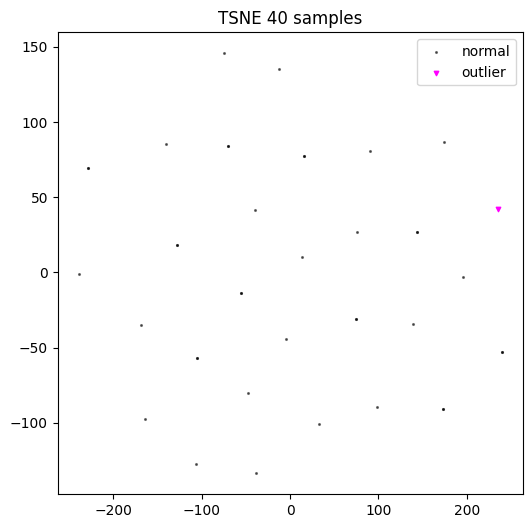

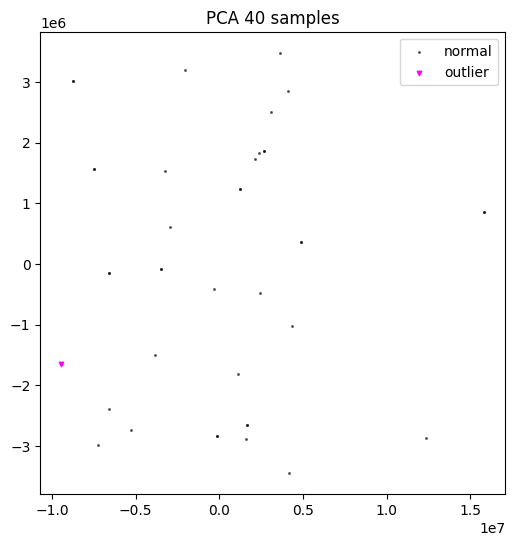

In [30]:
instance_reprs = StandardScaler().fit_transform(instance_reprs) if use_norm else instance_reprs
tsne = TSNE(n_jobs=12, perplexity=30, n_iter=1000)
reprs_2d_tsne = tsne.fit_transform(instance_reprs)
reprs_2d_pca = PCA().fit_transform(instance_reprs)
tsne_map(reprs_2d_tsne, outlier_labels)
pca_map(reprs_2d_pca, outlier_labels)

## TS2Vec Features

In [18]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
class_index = np.cumsum(num_of_series)
class_no = 1
use_norm = False
save = False
name = 'ts2vec'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
instance_reprs = np.load(reprs_path)
labels = np.load(labels_path)
path = Path(f'global2class_{name}_{instance_reprs.shape[1]}_global')
path.mkdir(exist_ok=True)
instance_reprs = instance_reprs[class_index[class_no-1]:class_index[class_no]]
labels = labels[class_index[class_no-1]:class_index[class_no]]

In [118]:
# Finch
class_no = 15
use_norm = False
save = False
name = 'ts2vec'
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy'
# labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
labels_path = r'./new_anomaly_labels.npy'
class_labels_path = r'./finch_class_labels.npy'

instance_reprs = np.load(reprs_path)
outlier_labels = np.load(labels_path)
class_labels = np.load(class_labels_path)
path = Path(f'global2class_{name}_{instance_reprs.shape[1]}_global')
path.mkdir(exist_ok=True)

instance_reprs = instance_reprs[class_labels==class_no]
outlier_labels = outlier_labels[class_labels==class_no]
have_outlier = outlier_labels.sum()
print(f'class_no:{class_no}, series:{instance_reprs.shape[0]}, have_outlier:{have_outlier}')

class_no:15, series:142, have_outlier:4


In [11]:
# new label
#class_no:0, series:354, have_outlier:0
#class_no:1, series:275, have_outlier:0
#class_no:2, series:177, have_outlier:0
#class_no:3, series:337, have_outlier:0
#class_no:4, series:280, have_outlier:0
#class_no:5, series:105, have_outlier:2
#class_no:6, series:194, have_outlier:1
#class_no:7, series:99, have_outlier:0
#class_no:8, series:149, have_outlier:0
#class_no:9, series:88, have_outlier:0
#class_no:10, series:227, have_outlier:0
#class_no:11, series:153, have_outlier:0
#class_no:12, series:48, have_outlier:0
#class_no:13, series:267, have_outlier:1
#class_no:14, series:113, have_outlier:0
#class_no:15, series:142, have_outlier:0
#class_no:16, series:94, have_outlier:2
#class_no:17, series:59, have_outlier:0

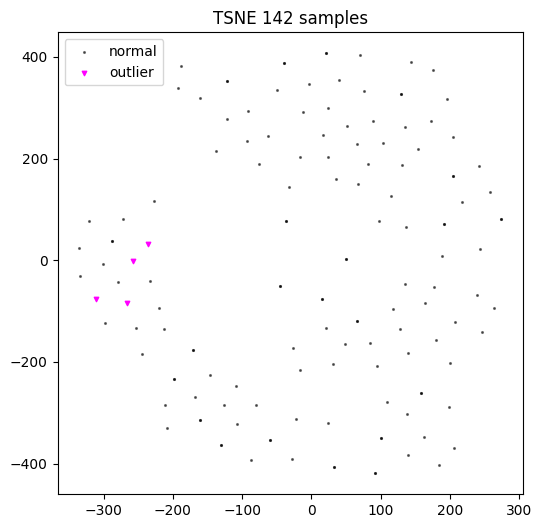

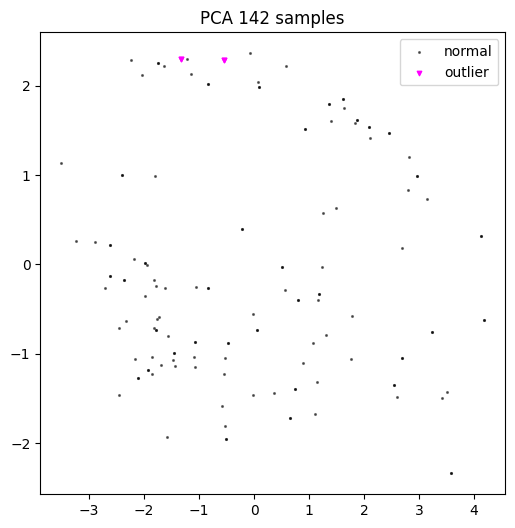

In [119]:
instance_reprs = StandardScaler().fit_transform(instance_reprs) if use_norm else instance_reprs
tsne = TSNE(n_jobs=12, perplexity=30, n_iter=2000)
reprs_2d_tsne = tsne.fit_transform(instance_reprs)
reprs_2d_pca = PCA().fit_transform(instance_reprs)
tsne_map(reprs_2d_tsne, outlier_labels, save=save, name=f'ts2vec_finch_{class_no}')
pca_map(reprs_2d_pca, outlier_labels, save=save, name=f'ts2vec_finch_{class_no}')

## CRT Features

In [ ]:
class_no = 10
use_norm = False
use_best = False
reprs_path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\crt_class_features_Last_128_exchange.npy'
reprs_best_path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\crt_class_features_128_exchange.npy'
labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\class_resample_8928\class_{class_no}\class_labels.npy'
reprs_random = fr'D:\Jupyter\TS Projects\CRT\random_encode.npy'
instance_reprs = np.load(reprs_path) if not use_best else np.load(reprs_best_path)
labels = np.load(labels_path)
path = Path(f'crt_class_{instance_reprs.shape[1]}')
path.mkdir(exist_ok=True)

In [ ]:
instance_reprs = StandardScaler().fit_transform(instance_reprs) if use_norm else instance_reprs
tsne = TSNE(n_jobs=12, perplexity=50, n_iter=1000)
reprs_2d_tsne = tsne.fit_transform(instance_reprs)
reprs_2d_pca = PCA().fit_transform(instance_reprs)
tsne_map(reprs_2d_tsne, labels)
pca_map(reprs_2d_pca, labels)

# RT 

In [82]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
class_index = np.cumsum(num_of_series)
class_no = 2
use_norm = False
use_random = False
save = False
name = 'rt'
reprs_path = fr'D:\Jupyter\TS Projects\RT\rt_model1_all_dataset_norm_Last_256_4.npy'
labels_path = fr'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy'
reprs_random = fr'D:\Jupyter\TS Projects\RT\rt_model1_all_dataset_norm_256_random.npy'
instance_reprs = np.load(reprs_path) if not use_random else np.load(reprs_random)
labels = np.load(labels_path)
path = Path(f'global2class_{name}_{instance_reprs.shape[1]}')
path.mkdir(exist_ok=True)
instance_reprs = instance_reprs[class_index[class_no-1]:class_index[class_no]]
labels = labels[class_index[class_no-1]:class_index[class_no]]

In [ ]:
instance_reprs = StandardScaler().fit_transform(instance_reprs) if use_norm else instance_reprs
tsne = TSNE(n_jobs=12, perplexity=50, n_iter=1000)
reprs_2d_tsne = tsne.fit_transform(instance_reprs)
reprs_2d_pca = PCA().fit_transform(instance_reprs)
tsne_map(reprs_2d_tsne, labels)
pca_map(reprs_2d_pca, labels)

# SimMTM

In [ ]:
path1 = r'D:\Jupyter\TS Projects\SimMTM\SimMTM_Classification\code\experiments_logs\battery\dataset\pre_train_5_pt_0.25_0.001_200\best.npy'
path2 = r'D:\Jupyter\TS Projects\SimMTM\SimMTM_Classification\code\experiments_logs\battery\dataset\pre_train_5_pt_0.25_0.001_200\random.npy'
path3 = r'D:\Jupyter\TS Projects\CRT\random_encode.npy'

In [ ]:
instance_reprs = np.load(path3)
# ss = StandardScaler()
# instance_reprs = ss.fit_transform(instance_reprs)

In [ ]:
tsne = TSNE(n_jobs=12, perplexity=50)
reprs_2d = tsne.fit_transform(instance_reprs)
tsne_map(reprs_2d, labels)

# Anomaly Detection Methods

## INNE

In [ ]:
# max_samples: 2-16 

In [ ]:
detector = INNE(n_estimators=300, max_samples=2, contamination=0.05)
detector.fit(instance_reprs)
anomaly_scores_inne = detector.decision_scores_
anomaly_labels_inne = detector.labels_.astype(bool)
print(detector.threshold_)
print(sum(anomaly_labels_inne))
anomaly_file_inne = np.arange(1, 9209)[anomaly_labels_inne.astype(bool)]

# top_100设置
top_100 = np.argsort(anomaly_scores_inne)[-100:]
top_100_label = np.zeros_like(anomaly_scores_inne)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_inne[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_inne)[::-1]
scores = anomaly_scores_inne[score_index]
files = np.arange(1, 9209)[score_index]

# ROC-PR
x_roc, y_roc, _ = roc_curve(labels, anomaly_scores_inne, pos_label=1)
y_prc, x_prc, _ = precision_recall_curve(labels, anomaly_scores_inne, pos_label=1)
auc_roc = auc(x_roc, y_roc)
auc_pr = auc(x_prc[::-1], y_prc[::-1])
print(f'AUC-ROC:{auc_roc:.4f}')
print(f'AUC-PR:{auc_pr:.5f}')

In [120]:
use_pr_inne = True
run_time = 10
params = [i for i in range(2, 60)]
# params = [i for i in range(16, 17)]

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_inne = {'max_samples':p}
    auc_roc_inne, auc_pr_inne, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, inne_func, args_inne
                                                                         , run_time=run_time, use_pr=use_pr_inne)
    if not use_pr_inne:
        if auc_roc_inne > best_roc:
            best_roc = auc_roc_inne
            best_pr = auc_pr_inne
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_inne > best_pr:
            best_roc = auc_roc_inne
            best_pr = auc_pr_inne
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_inne, anomaly_rank_inne = best_scores, best_rank
    np.save(path / f'anomaly_scores_inne_{name}_class{class_no}_finch.npy', anomaly_scores_inne)
    np.save(path / f'anomaly_scores_rank_inne_{name}_class{class_no}_finch.npy', anomaly_rank_inne)

  0%|          | 0/58 [00:00<?, ?it/s]

AUC-ROC:0.8405797101449275
AUC-PR:0.07681080094873198
best p:4


In [ ]:
# ts2vec-global
class1 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':21}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':2}
class10 = {'AUC-ROC':0.8351, 'AUC-PR':0.3161, 'max_samples':2}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':2}
class12 = {'AUC-ROC':0.6167, 'AUC-PR':0.0886, 'max_samples':24}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':2}
class14= {'AUC-ROC':0.9231, 'AUC-PR':0.1, 'max_samples':15}
# tsfel
class1 = {'AUC-ROC':0.98, 'AUC-PR':0.0995, 'max_samples':5}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':28}
class10 = {'AUC-ROC':0.6192, 'AUC-PR':0.2364, 'max_samples':2}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':2}
class12 = {'AUC-ROC':0.4533, 'AUC-PR':0.0679, 'max_samples':10}
class13 = {'AUC-ROC':0.9831, 'AUC-PR':0.25, 'max_samples':2}
class14= {'AUC-ROC':0.9808, 'AUC-PR':0.25, 'max_samples':17}
mix = {'AUC-ROC':0.9906, 'AUC-PR':0.3539, 'max_samples':17}
# ts2vec_finch
class5 = {'AUC-ROC':1, 'AUC-PR'1, 'max_samples':3}
class6 = {'AUC-ROC':1, 'AUC-PR'1, 'max_samples':8}
class13 = {'AUC-ROC':1, 'AUC-PR'1, 'max_samples':7}
class16 = {'AUC-ROC':1, 'AUC-PR'1, 'max_samples':6}
# tsfel_finch
class0 = {'AUC-ROC':0.9926, 'AUC-PR'0.0385, 'max_samples':33}
class5 = {'AUC-ROC':0.7746, 'AUC-PR':0.3717, 'max_samples':59}
class8 = {'AUC-ROC':1, 'AUC-PR'1, 'max_samples':2}
class9 = {'AUC-ROC':0.9487, 'AUC-PR'0.1667, 'max_samples':17}

## LOF-euclidean

In [ ]:
detector_lof = LOF(contamination=0.06, n_jobs=13, novelty=True, n_neighbors=25, metric='euclidean')
detector_lof.fit(instance_reprs)
anomaly_labels_lof = detector_lof.labels_.astype(bool)
anomaly_scores_lof = detector_lof.decision_scores_
min_s, max_s = anomaly_scores_lof.min(), anomaly_scores_lof.max()
anomaly_scores_lof = (anomaly_scores_lof-min_s) / (max_s-min_s)
anomaly_file_lof = np.arange(1, 9209)[anomaly_labels_lof.astype(bool)]
print('threshold:', (detector_lof.threshold_-min_s) / (max_s - min_s))
print(f'anomaly numbers:', sum(anomaly_labels_lof))
top_100 = np.argsort(anomaly_scores_lof)[-100:]
top_100_label = np.zeros_like(anomaly_scores_lof)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_lof[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_lof)[::-1]
scores = anomaly_scores_lof[score_index]
files = np.arange(1, 9209)[score_index]

In [114]:
use_pr_lof = True
run_time = 1
params = np.arange(2, 250, 1)
# params = np.arange(10, 11)

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_lof = {'n_neighbors':p}
    auc_roc_lof, auc_pr_lof, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, lof_func, args_lof, run_time=run_time, use_pr=use_pr_lof)
    if not use_pr_lof:
        if auc_roc_lof > best_roc:
            best_roc = auc_roc_lof
            best_pr = auc_pr_lof
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_lof > best_pr:
            best_roc = auc_roc_lof
            best_pr = auc_pr_lof
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_lof, anomaly_rank_lof = best_scores, best_rank
    np.save(path / f'anomaly_scores_lof_{name}_class{class_no}_finch.npy', anomaly_scores_lof)
    np.save(path / f'anomaly_scores_rank_lof_{name}_class{class_no}_finch.npy', anomaly_rank_lof)

  0%|          | 0/248 [00:00<?, ?it/s]

AUC-ROC:0.8501585623678647
AUC-PR:0.3273293220267307
best p:125


In [380]:
# ts2vec-global
class1 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':3}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class10 = {'AUC-ROC':0.8491, 'AUC-PR':0.32, 'n_neighbors':123}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class12= {'AUC-ROC':0.8633, 'AUC-PR':0.2727, 'n_neighbors':64}
class13= {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class14= {'AUC-ROC':0.9808, 'AUC-PR':0.25, 'n_neighbors':51}
# tsfel
class1 = {'AUC-ROC':0.9762, 'AUC-PR':0.0778, 'n_neighbors':201}
class2 = {'AUC-ROC':0.9967, 'AUC-PR':0.1667, 'n_neighbors':235}
class10 = {'AUC-ROC':0.7619, 'AUC-PR':0.3657, 'n_neighbors':190}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':3}
class12= {'AUC-ROC':0.82, 'AUC-PR':0.1693, 'n_neighbors':60}
class13= {'AUC-ROC':0.9830, 'AUC-PR':0.25, 'n_neighbors':2}
class14= {'AUC-ROC':0.9615, 'AUC-PR':0.1667, 'n_neighbors':2}
mix = {'AUC-ROC':0.8191, 'AUC-PR':0.1534, 'n_neighbors':2}
# ts2vec_finch
class5 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':9}
class6 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':4}
class13 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':5}
class16 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':2}
# tsfel_finch
class0 = {'AUC-ROC':0.9938, 'AUC-PR'0.0455, 'n_neighbors':9}
class5 = {'AUC-ROC':0.8587, 'AUC-PR':0.3633, 'n_neighbors':52}
class8 = {'AUC-ROC':0.5, 'AUC-PR'0.67, 'n_neighbors':2}
class9 = {'AUC-ROC':0.9231, 'AUC-PR'0.125, 'n_neighbors':16}

## COF

In [ ]:
detector_cof = COF(contamination=0.06, n_neighbors=2)
detector_cof.fit(instance_reprs)
anomaly_labels_cof = detector_cof.labels_.astype(bool)
anomaly_scores_cof = detector_cof.decision_scores_
min_s, max_s = anomaly_scores_cof.min(), anomaly_scores_cof.max()
anomaly_scores_cof = (anomaly_scores_cof-min_s) / (max_s-min_s)
anomaly_file_cof = np.arange(1, 9209)[anomaly_labels_cof.astype(bool)]
print('threshold:', (detector_cof.threshold_-min_s) / (max_s - min_s))
print(f'anomaly numbers:', sum(anomaly_labels_cof))
top_100 = np.argsort(anomaly_scores_cof)[-100:]
top_100_label = np.zeros_like(anomaly_scores_cof)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_cof[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_cof)[::-1]
scores = anomaly_scores_cof[score_index]
files = np.arange(1, 9209)[score_index]

In [115]:
use_pr_cof = True
run_time = 1
params = np.arange(2, 100, 1).tolist()

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_cof = {'n_neighbors':p}
    auc_roc_cof, auc_pr_cof, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, cof_func, args_cof, run_time=run_time, use_pr=use_pr_cof)
    if not use_pr_cof:
        if auc_roc_cof > best_roc:
            best_roc = auc_roc_cof
            best_pr = auc_pr_cof
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_cof > best_pr:
            best_roc = auc_roc_cof
            best_pr = auc_pr_cof
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_cof, anomaly_rank_cof = best_scores, best_rank
    np.save(path / f'anomaly_scores_cof_{name}_class{class_no}_finch.npy', anomaly_scores_cof)
    np.save(path / f'anomaly_scores_rank_cof_{name}_class{class_no}_finch.npy', anomaly_rank_cof)

  0%|          | 0/98 [00:00<?, ?it/s]

AUC-ROC:0.6065010570824524
AUC-PR:0.32115270180146094
best p:18


In [ ]:
# ts2vec-global
class1 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':6}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':3}
class10 = {'AUC-ROC':0.5878, 'AUC-PR':0.2706, 'n_neighbors':18}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class12 = {'AUC-ROC':0.6367, 'AUC-PR':0.1069, 'n_neighbors':30}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class14 = {'AUC-ROC':0.9808, 'AUC-PR':0.25, 'n_neighbors':4}
# tsfel
class1 = {'AUC-ROC':0.9771, 'AUC-PR':0.0826, 'n_neighbors':87}
class2 = {'AUC-ROC':0.9933, 'AUC-PR':0.1, 'n_neighbors':4}
class10 = {'AUC-ROC':0.5327, 'AUC-PR':0.2061, 'n_neighbors':109}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':3}
class12 = {'AUC-ROC':0.5233, 'AUC-PR':0.0771, 'n_neighbors':10}
class13 = {'AUC-ROC':0.9831, 'AUC-PR':0.25, 'n_neighbors':2}
class14 = {'AUC-ROC':0.9808, 'AUC-PR':0.25, 'n_neighbors':2}
mix = {'AUC-ROC':0.8119, 'AUC-PR':0.1457, 'n_neighbors':2}
# ts2vec_finch
class5 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':12}
class6 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':10}
class13 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':7}
class16 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':3}
# tsfel_finch
class0 = {'AUC-ROC':0.9937, 'AUC-PR':0.0455, 'n_neighbors':13}
class5 = {'AUC-ROC':0.746, 'AUC-PR':0.3966, 'n_neighbors':3}
class8 = {'AUC-ROC':1, 'AUC-PR'1, 'n_neighbors':2}
class9 = {'AUC-ROC':0.8462, 'AUC-PR'0.0714, 'n_neighbors':3}

## EIF

In [ ]:
eif = EIF(sub_size=2, contamination=0.06, n_estimators=300)
eif.fit(instance_reprs)
anomaly_labels_eif = eif.label.astype(bool)
anomaly_scores_eif = eif.scores
min_s, max_s = anomaly_scores_eif.min(), anomaly_scores_eif.max()
anomaly_scores_eif = (anomaly_scores_eif-min_s) / (max_s-min_s)
anomaly_file_eif = np.arange(1, 9209)[anomaly_labels_eif.astype(bool)]
print('threshold:', (eif.threshold-min_s) / (max_s - min_s))
print(f'anomaly numbers:', sum(anomaly_labels_eif))
top_100 = np.argsort(anomaly_scores_eif)[-100:]
top_100_label = np.zeros_like(anomaly_scores_eif)
top_100_label[top_100] = 1
anomaly_files = top_100 + 1
anomaly_score = anomaly_scores_eif[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_eif)[::-1]
scores = anomaly_scores_eif[score_index]
files = np.arange(1, 9209)[score_index]

In [116]:
use_pr_eif = True
run_time = 10
params = [i for i in range(4, 20, 2)]
# params = [i for i in range(4, 5)]
# 
best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue 
    args_eif = {'sub_size':p}
    auc_roc_eif, auc_pr_eif, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, eif_func, args_eif, run_time=run_time, use_pr=use_pr_eif)
    if not use_pr_eif:
        if auc_roc_eif > best_roc:
            best_roc = auc_roc_eif
            best_pr = auc_pr_eif
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_eif > best_pr:
            best_roc = auc_roc_eif
            best_pr = auc_pr_eif
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_eif, anomaly_rank_eif = best_scores, best_rank
    np.save(path / f'anomaly_scores_eif_{name}_class{class_no}_finch.npy', anomaly_scores_eif)
    np.save(path / f'anomaly_scores_rank_eif_{name}_class{class_no}_finch.npy', anomaly_rank_eif)

  0%|          | 0/8 [00:00<?, ?it/s]

AUC-ROC:0.7139270613107822
AUC-PR:0.2716236361342732
best p:6


In [ ]:
## ts2vec-global
class1 = {'AUC-ROC':0.9995, 'AUC-PR':0.9333, 'max_samples':4}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class10 = {'AUC-ROC':0.6559, 'AUC-PR':0.3035, 'max_samples':4}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class12 = {'AUC-ROC':0.7333, 'AUC-PR':0.1466, 'max_samples':4}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class14 = {'AUC-ROC':0.7692, 'AUC-PR':0.0385, 'max_samples':14}
## tsfel
class1 = {'AUC-ROC':0.9814, 'AUC-PR':0.0987, 'max_samples':6}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class10 = {'AUC-ROC':0.5292, 'AUC-PR':0.2450, 'max_samples':4}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class12 = {'AUC-ROC':0.4133, 'AUC-PR':0.06, 'max_samples':8}
class13 = {'AUC-ROC':0.9831, 'AUC-PR':0.25, 'max_samples':4}
class14 = {'AUC-ROC':0.9231, 'AUC-PR':0.1, 'max_samples':4}
mix = {'AUC-ROC':0.9536, 'AUC-PR':0.3023, 'max_samples':4}
# ts2vec_finch
class5 = {'AUC-ROC':0.9976, 'AUC-PR':0.9167, 'max_samples':4}
class6 = {'AUC-ROC':0.9896, 'AUC-PR':0.1667, 'max_samples':4}
class13 = {'AUC-ROC':0.9624, 'AUC-PR':0.0455, 'max_samples':18}
class16 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
# tsfel_finch
class0 = {'AUC-ROC':0.7638, 'AUC-PR':0.0013, 'max_samples':4}
class5 = {'AUC-ROC':0.8127, 'AUC-PR':0.4203, 'max_samples':4}
class8 = {'AUC-ROC':0.9455, 'AUC-PR':0.03125, 'max_samples':12} # fail
class9 = {'AUC-ROC':0.923, 'AUC-PR':0.125, 'max_samples':6}

## IF

In [ ]:
ifs = EIF(sub_size=2, contamination=0.06, extension=0, n_estimators=200)
ifs.fit(instance_reprs)
anomaly_labels_ifs = ifs.label.astype(bool)
anomaly_scores_ifs = ifs.scores
min_s, max_s = anomaly_scores_ifs.min(), anomaly_scores_ifs.max()
anomaly_scores_ifs = (anomaly_scores_ifs-min_s) / (max_s-min_s)
anomaly_file_ifs = np.arange(1, 9209)[anomaly_labels_ifs.astype(bool)]
print('threshold:', (ifs.threshold-min_s) / (max_s - min_s))
print(f'anomaly numbers:', sum(anomaly_labels_ifs))
top_100 = np.argsort(anomaly_scores_ifs)[-100:]
top_100_label = np.zeros_like(anomaly_scores_ifs)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_ifs[top_100]

In [85]:
use_pr_if = True
run_time = 10
# params = [4, 8, 16]
params = [i for i in range(4, 10, 2)]

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_if = {'sub_size':p}
    auc_roc_if, auc_pr_if, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, if_func, args_if, run_time=run_time, use_pr=use_pr_if)
    if not use_pr_if:
        if auc_roc_if > best_roc:
            best_roc = auc_roc_if
            best_pr = auc_pr_if
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_if > best_pr:
            best_roc = auc_roc_if
            best_pr = auc_pr_if
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_if, anomaly_rank_if = best_scores, best_rank
    np.save(path / f'anomaly_scores_if_{name}_class{class_no}_finch.npy', anomaly_scores_if)
    np.save(path / f'anomaly_scores_rank_if_{name}_class{class_no}_finch.npy', anomaly_rank_if)

  0%|          | 0/3 [00:00<?, ?it/s]

AUC-ROC:0.9951456310679612
AUC-PR:0.7916666666666666
best p:4


In [84]:
# ts2vec-global
class1 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class10 = {'AUC-ROC':0.691, 'AUC-PR':0.2254, 'max_samples':6}
class11 = {'AUC-ROC':0.9917, 'AUC-PR':0.25, 'max_samples':4}
class12 = {'AUC-ROC':0.4566, 'AUC-PR':0.0673, 'max_samples':4}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class14 = {'AUC-ROC':0.5, 'AUC-PR':0.0185, 'max_samples':6}
# tsfel
class1 = {'AUC-ROC':0.9372, 'AUC-PR':0.0314, 'max_samples':8}
class2 = {'AUC-ROC':0.9684, 'AUC-PR':0.025, 'max_samples':6}
class10 = {'AUC-ROC':0.3942, 'AUC-PR':0.1018, 'max_samples':6}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class12 = {'AUC-ROC':0.3433, 'AUC-PR':0.0553, 'max_samples':6}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class14 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':6}
mix = {'AUC-ROC':0.9475, 'AUC-PR':0.2555, 'max_samples':6}
# ts2vec_finch
class5 = {'AUC-ROC':0.9951, 'AUC-PR':0.7917, 'max_samples':4}
class6 = {'AUC-ROC':0.9741, 'AUC-PR':0.0833, 'max_samples':6}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
class16 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4}
# tsfel_finch
class0 = {'AUC-ROC':0.81, 'AUC-PR':0.0016, 'max_samples':4}
class5 = {'AUC-ROC':0.9317, 'AUC-PR':0.1401, 'max_samples':8}
class8 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':4} # fail
class9 = {'AUC-ROC':0.641, 'AUC-PR':0.0333, 'max_samples':4}

## KNN

In [ ]:
knn = KNN(n_neighbors=60, method='mean', metric='euclidean', n_jobs=13)
knn.fit(instance_reprs)
anomaly_labels_knn = knn.labels_.astype(bool)
anomaly_scores_knn = knn.decision_scores_
min_s, max_s = anomaly_scores_knn.min(), anomaly_scores_knn.max()
anomaly_scores_knn = (anomaly_scores_knn-min_s) / (max_s-min_s)
anomaly_file_knn = np.arange(1, 9209)[anomaly_labels_knn.astype(bool)]
print('threshold:', (knn.threshold_-min_s) / (max_s - min_s))
print(f'anomaly numbers:', sum(anomaly_labels_knn))
top_100 = np.argsort(anomaly_scores_knn)[-100:]
top_100_label = np.zeros_like(anomaly_scores_knn)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_knn[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_knn)[::-1]
scores = anomaly_scores_knn[score_index]
files = np.arange(1, 9209)[score_index]

In [80]:
use_pr_knn = True
run_time = 1
params = np.arange(2, 200, 1)

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_knn = {'n_neighbors':p}
    auc_roc_knn, auc_pr_knn, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, knn_func, args_knn, run_time=run_time, use_pr=use_pr_knn)
    if not use_pr_knn:
        if auc_roc_knn > best_roc:
            best_roc = auc_roc_knn
            best_pr = auc_pr_knn
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_knn > best_pr:
            best_roc = auc_roc_knn
            best_pr = auc_pr_knn
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_knn, anomaly_rank_knn = best_scores, best_rank
    np.save(path / f'anomaly_scores_knn_{name}_class{class_no}_finch.npy', anomaly_scores_knn)
    np.save(path / f'anomaly_scores_rank_knn_{name}_class{class_no}_finch.npy', anomaly_rank_knn)

  0%|          | 0/198 [00:00<?, ?it/s]

AUC-ROC:1.0
AUC-PR:1.0
best p:63


In [ ]:
# ts2vec-global
class1 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class10 = {'AUC-ROC'0.7849, 'AUC-PR':0.3004, 'n_neighbors':114}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class12 = {'AUC-ROC':0.6217, 'AUC-PR':0.0895, 'n_neighbors':3}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class14 = {'AUC-ROC':0.8462, 'AUC-PR':0.0555, 'n_neighbors':2}
# tsfel
class1 = {'AUC-ROC':0.9814, 'AUC-PR':0.0961, 'n_neighbors':2}
class2 = {'AUC-ROC':0.9967, 'AUC-PR':0.1667, 'n_neighbors':2}
class10 = {'AUC-ROC'0.6132, 'AUC-PR':0.2380, 'n_neighbors':147}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class12 = {'AUC-ROC':0.6667, 'AUC-PR':0.1009, 'n_neighbors':3}
class13 = {'AUC-ROC':0.9831, 'AUC-PR':0.25, 'n_neighbors':2}
class14 = {'AUC-ROC':0.9231, 'AUC-PR':0.1, 'n_neighbors':2}
mix = {'AUC-ROC':0.8235, 'AUC-PR':0.1609, 'n_neighbors':2}
# ts2vec_finch
class5 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class6 = {'AUC-ROC':0.9948, 'AUC-PR':0.25, 'n_neighbors':2}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2}
class16 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':63}
# tsfel_finch
class0 = {'AUC-ROC':0.9907, 'AUC-PR':0.0313, 'n_neighbors':2}
class5 = {'AUC-ROC':0.9079, 'AUC-PR':0.3783, 'n_neighbors':2}
class8 = {'AUC-ROC':1, 'AUC-PR':1, 'n_neighbors':2} # fail
class9 = {'AUC-ROC':0.9744, 'AUC-PR':0.25, 'n_neighbors':2}

## DIF

In [ ]:
dif = DeepIsolationForest(n_jobs=13, device='cpu', max_samples=256, n_estimators=50, rep_dim=128, hidden_dims='100,50'
                         , act='ReLU', n_ensemble=50)
dif.fit(instance_reprs)
anomaly_scores_dif = dif.decision_scores_
min_s, max_s = anomaly_scores_dif.min(), anomaly_scores_dif.max()
anomaly_scores_dif = (anomaly_scores_dif-min_s) / (max_s-min_s)
print('threshold:', (dif.threshold_-min_s) / (max_s - min_s))
top_100 = np.argsort(anomaly_scores_dif)[-100:]
top_100_label = np.zeros_like(anomaly_scores_dif)
top_100_label[top_100] = 1
anomaly_files = top_100+1
anomaly_score = anomaly_scores_dif[top_100]

# auc计算设置, 文件名按照异常分从高向低排序
score_index = np.argsort(anomaly_scores_dif)[::-1]
scores = anomaly_scores_dif[score_index]
files = np.arange(1, 9209)[score_index]

In [81]:
use_pr_dif = True
run_time = 10
# params = [i for i in range(4, 30, 2)]
params = [i for i in range(30, 70, 2)]
best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_dif = {'max_samples':p}
    auc_roc_dif, auc_pr_dif, anomaly_scores, socres_rank = best_report(instance_reprs, outlier_labels, dif_func, args_dif, run_time=run_time, use_pr=use_pr_dif)
    if not use_pr_dif:
        if auc_roc_dif > best_roc:
            best_roc = auc_roc_dif
            best_pr = auc_pr_dif
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_dif > best_pr:
            best_roc = auc_roc_dif
            best_pr = auc_pr_dif
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')
if save:
    anomaly_scores_dif, anomaly_rank_dif = best_scores, best_rank
    np.save(path / f'anomaly_scores_dif_{name}_class{class_no}_finch.npy', anomaly_scores_dif)
    np.save(path / f'anomaly_scores_rank_dif_{name}_class{class_no}_finch.npy', anomaly_rank_dif)

  0%|          | 0/20 [00:00<?, ?it/s]

AUC-ROC:0.9945652173913043
AUC-PR:0.7916666666666666
best p:30


In [ ]:
# ts2vec-global
class1 = {'AUC-ROC':0.9971, 'AUC-PR':0.3778, 'max_samples':46}
class2 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':30}
class10 = {'AUC-ROC':0.7522, 'AUC-PR'::0.2788, 'max_samples':30}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':30}
class12 = {'AUC-ROC':0.5633, 'AUC-PR':0.0803, 'max_samples':46}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':30}
class14 = {'AUC-ROC':0.6731, 'AUC-PR':0.0278, 'max_samples':46}
# tsfel
class1 = {'AUC-ROC':0.9771, 'AUC-PR':0.0799, 'max_samples':50}
class2 = {'AUC-ROC':0.9867, 'AUC-PR':0.0556, 'max_samples':32}
class10 = {'AUC-ROC':0.4831, 'AUC-PR':0.1886, 'max_samples':32}
class11 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':30}
class12 = {'AUC-ROC':0.32, 'AUC-PR':0.0559, 'max_samples':34}
class13 = {'AUC-ROC':0.9831, 'AUC-PR':0.25, 'max_samples':30}
class14 = {'AUC-ROC':0.9615, 'AUC-PR':0.1667, 'max_samples':46}
mix = {'AUC-ROC':0.9171, 'AUC-PR':0.1491, 'max_samples':46}
# ts2vec_finch
class5 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':30}
class6 = {'AUC-ROC':0.9793, 'AUC-PR':0.1, 'max_samples':52}
class13 = {'AUC-ROC':1, 'AUC-PR':1, 'max_samples':62}
class16 = {'AUC-ROC':0.9946, 'AUC-PR':0.7917, 'max_samples':30}
# tsfel_finch
class0 = {'AUC-ROC':0.9392, 'AUC-PR':0.005, 'max_samples':66}
class5 = {'AUC-ROC':0.8571, 'AUC-PR':0.3617, 'max_samples':62}
class8 = {'AUC-ROC':0.9924, 'AUC-PR':0.1666, 'max_samples':30} # fail
class9 = {'AUC-ROC':0.9231, 'AUC-PR':0.125, 'max_samples':32}

# 全数据异常分析

In [12]:
num_of_series = [0, 702, 602, 63, 288, 120, 59, 103, 116, 50, 193, 121, 65, 60, 53, 67, 49, 96, 48, 106, 200]
num_of_series= np.cumsum(num_of_series)
instance_reprs = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\ts2vec_256_reprs_global.npy')
labels = np.load(r'D:\Jupyter\AD\datasets-ad\battery\all_data_resample_8928\all_data_labels.npy')
# 区分出每个类别
class_reprs = [reprs[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [labels[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
new_labels = []
for i in range(len(class_labels)):
    if (i+1) in [1, 2, 11, 13]:
        new_labels.append(class_labels[i])
    else:
        new_labels.append(np.zeros(class_labels[i].shape[0]))
new_labels = np.concatenate(new_labels, axis=0)

In [77]:
use_pr_inne = True
run_time = 10
params = [i for i in range(2, 30)]
# params = [i for i in range(9, 30)]

best_roc, best_pr = 0, 0
best_p = 2
best_scores, best_rank = None, None
for p in tqdm(params):
    if p >= instance_reprs.shape[0]:
        continue
    args_inne = {'max_samples':p}
    auc_roc_inne, auc_pr_inne, anomaly_scores, socres_rank = best_report(instance_reprs, new_labels, inne_func, args_inne
                                                                         , run_time=run_time, use_pr=use_pr_inne)
    if not use_pr_inne:
        if auc_roc_inne > best_roc:
            best_roc = auc_roc_inne
            best_pr = auc_pr_inne
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
    else:
        if auc_pr_inne > best_pr:
            best_roc = auc_roc_inne
            best_pr = auc_pr_inne
            best_p = p
            best_scores = anomaly_scores
            best_rank = socres_rank
        
print(f'AUC-ROC:{best_roc}')
print(f'AUC-PR:{best_pr}')
print(f'best p:{best_p}')

  0%|          | 0/28 [00:00<?, ?it/s]

AUC-ROC:0.9524035921817222
AUC-PR:0.256407764409751
best p:28


In [ ]:
reprs_2d = TSNE(perplexity=21, metric='cosine', n_iter=2000, init='pca').fit_transform(instance_reprs)
# 区分出每个类别
class_reprs = [reprs_2d[num_of_series[i]:num_of_series[i+1]] for i in range(len(num_of_series)-1)]
class_labels = [np.full(each.shape[0], idx+1) for idx, each in enumerate(class_reprs)]

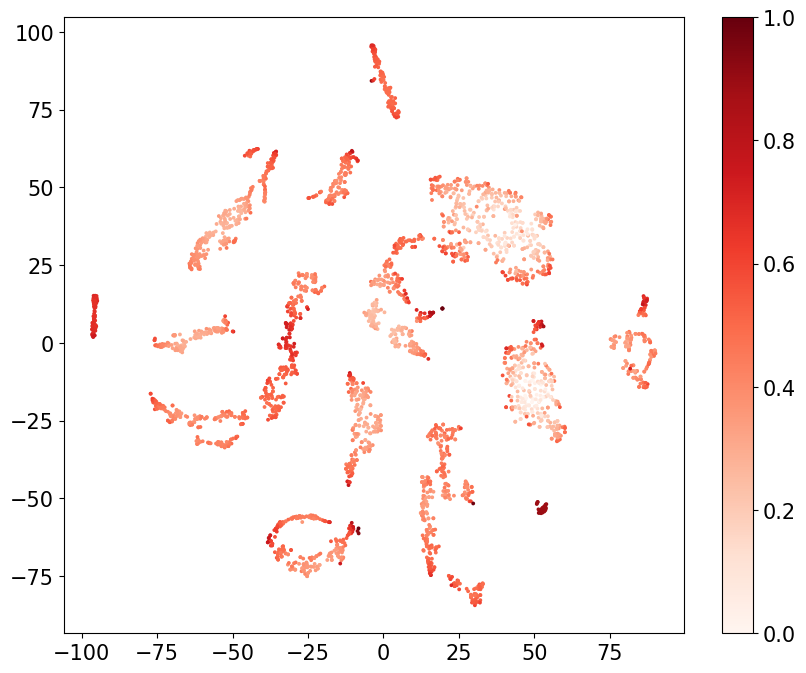

In [80]:
anomaly_scores = (best_scores - best_scores.min()) / (best_scores.max() - best_scores.min())
# anomaly_scores = best_scores
plt.figure(figsize=(10, 8))
plt.scatter(reprs_2d[:, 0], reprs_2d[:, 1], s=3, cmap=plt.get_cmap('Reds'), c=anomaly_scores)
colorbar = plt.colorbar()
colorbar.ax.tick_params(labelsize=15)
plt.tick_params(labelsize=15)
plt.savefig(f'./visualize/anomaly_score_distrubution_tsne_inne.png', dpi=1000)
plt.show()